In [45]:
import numpy as np
import sympy as sp
import os
from queue import PriorityQueue

import matplotlib.pyplot as plt

In [51]:
#node size ratio (unit/node)
def map():
    global x_size, y_size, map_def
   
    x_size = int(400/Rat) #x and y  as per gloabl coordinate system and not matrix
    y_size = int(250/Rat)
    map_def = np.zeros((y_size,x_size,12))
    map_def[:,:,:] = -2

"""Common obstacle code"""



"""Circle"""

#x is column and y is row for the matrix
def circle_obs():
    global x_c, y_c, x_nc, y_nc, map_obs1, allp_map
    x_c = []
    y_c = []
    x_nc = []
    y_nc = []
    y_centre = int((249 - 65)/Rat)
    x_centre = int((399 - 100)/Rat)
    radius_c = int(55/Rat) #radius of cicle including clearance
    radius = int(40/Rat)
    map_obs1 = np.copy(map_def) # a deep copy #chnage this to map_obs1
    for x in range(int(240/Rat),int(360/Rat)):
        for y in range(int(120/Rat), int(240/Rat)):
            if (np.sqrt((x-x_centre)**2 + (y-y_centre)**2)) < radius_c:
                map_obs1[y, x,:] = -1 #obstacle space updated as -1
                x_c.append(x) #to be used for plotting
                y_c.append(y)
                allp_map.append([x,y]) #to be used for visualisation on pygame
            if (np.sqrt((x-x_centre)**2 + (y-y_centre)**2)) < radius:
                x_nc.append(x) #list of obstacle without clearance
                y_nc.append(y)

"""Triangles"""
def triang_obs():
    global x_t1, y_t1, x_t1_nc, y_t1_nc, map_obs2, x_t2_nc, y_t2_nc, x_t2, y_t2, allp_map, Rat
    x_t1 = []
    y_t1 = []
    x_t2 = []
    y_t2 = []
    map_obs2 = np.copy(map_obs1)
    for x in range(int(170/Rat)):
        for y in range(int(40*Rat),int(240/Rat)):
            if (y - (6/7)*x - ((779/7) + 15)/Rat)<=0 and (y - (-85/69)*x - ((15880/69) -18)/Rat)>=0 and (y - (-16/5)*x - ((2169/5) +25)/Rat)<=0 :
                map_obs2[y,x,:] = -1
                x_t1.append(x)
                y_t1.append(y)
                allp_map.append([x,y])
            if (y - (6/7)*x - ((779/7) - 15)/Rat)>=0 and (y - (-85/69)*x - ((15880/69) -18)/Rat)>=0 and (y - (25/79)*x - ((13661/79) +15)/Rat)<=0:
                map_obs2[y,x,:] = -1
                x_t2.append(x)
                y_t2.append(y)
                allp_map.append([x,y])

"""Hexagon"""

def hex_obs():
    global map_obs4, x_h, y_h, x_h_nc, y_h_nc, allp_map
    x_h = []
    y_h = []
    map_obs4 = np.copy(map_obs2)
    for x in range(int(148/Rat), int(252/Rat)):
        for y in range(int(30/Rat),int(165/Rat)):
            if (y - (5/8)*x + 81/Rat)>=0 and (y + (5/8)*x - 281/Rat)<=0 and (y - (5/8)*x - 31/Rat)<=0 and (y + (5/8)*x - 169/Rat)>=0 and (x - 249/Rat)<=0 and (x - 150/Rat)>=0:
                map_obs4[y,x,:] = -1
                x_h.append(x)
                y_h.append(y)
                allp_map.append([x,y])

"""The main algorithm

Data structure
"""

class Node:
    def __init__(self, node_id, node_loc, parent_id, c2c , c2g):
        self.parent_id = parent_id #
        self.node_id = node_id #unique node id for each node
        self.node_loc = node_loc ## [y,x,angle]
        self.c2c= round(c2c,0)
        self.c2g=round(c2g,2)
        self.total_cost = round(c2c+c2g,2)

def pop(Closed_list, Open_list, All_list):
    dat = Open_list.get()
    #dat[0] is c2c+c2g, dat[1] is Node_id--> starts from 1, list starts from 0 
    Closed_list.append(All_list[dat[1]-1]) #indexing the node from the all_list  
    ##check for goal
    print('closed list updated')
    if All_list[dat[1]-1].node_loc in goal_list:
        goal_id=dat[1]-1
        print('this will be done at', All_list[dat[1]-1].node_loc )
        print('the goal coast is', All_list[dat[1]-1].total_cost)
        return "Goal found", goal_id
    return 1, All_list[dat[1]-1]

"""Cost Dictionary"""

cost_direction = {'S': 1, 'D': 1}

"""Parameter update"""

def param(All_list, Open_list, map_obs4, cost_dir, n_c, n_d,ang, node):
     id = All_list[-1].node_id + 1
     map_obs4[n_c,n_d,int(ang/30)] = id  ## id is updated in map
     c2_g=c2g([n_c,n_d],goal_location[0:2])
     c2c=node.c2c+cost_dir
     cost = c2c+c2_g  #cost_dir is a dictionary
     parent = node.node_id
     loc = [n_c, n_d, int(ang/30)]
     # print('node at id', id, 'cost is', cost, 'loc', loc)
     All_list.append(Node(id, loc, parent, c2c,c2_g)) ## node is created
     tup_new = [cost, id]
     Open_list.put(tup_new) ## list of [cost, id] ###gives the [cost,id] in priority queue open list

"""List cost update function

All cost needs to be rounded off to 2 due to euclidean distance
"""

def cost_update(nod, n_c ,n_d, ang, All_list,  Closed_list, Open_list, map_obs4, cost_dir):
     index = int(map_obs4[n_c, n_d, int(ang/30)])
     if round((nod.c2c + cost_dir),1)< round(All_list[index-1].c2c,1): #since index/node_id is starting from 1
            All_list[index-1].c2c = round((nod.c2c + cost_dir),1)
            All_list[index-1].parent_id = nod.node_id
            print('updated cost of node', index, 'is', All_list[index-1].total_cost)
            # for i in Closed_list:
            #     if i.node_id ==index:
            #             i.c2c = round((nod.c2c + cost_dir),1)
            #             i.parent_id = nod.node_id
            if Open_list.qsize() > 0:
                for j in Open_list.queue:
                    if j[1] ==index:
                            j[0] = round((nod.c2c + cost_dir),1)
                            # i.parent_id = nod.node_id

"""Check if goal function"""

# def check_if_goal(goal_loc, A_list, go_cost):
#     # print('checking goal')
#     if goal_loc==A_list[-1].node_loc:
#         go_cost = A_list[-1].cost #updates the goal cost
#         print('goal cost is', go_cost)
#         return go_cost
#     else:
#         return None

def move_zero(node, All_list, Open_list, k):
    a,b, node_k =node.node_loc
    angle=node_k*30
    ang=(angle+k*30)%360
    c= a + (L*np.sin(ang*(np.pi/180)))/Rat #needs to be according to the matrix
    d= b + (L*np.cos(ang*(np.pi/180)))/Rat
    n_c, n_d=thres_round(c,d)
    print(n_c, n_d, ang)
    if (9/Rat)<=(n_c)<=(y_size-1) and (9/Rat)<=n_d<=(x_size-1): 
        if map_obs4[n_c,n_d,int(ang/30)]==-2:
            param(All_list, Open_list, map_obs4, cost_direction['S'], n_c, n_d, ang, node) 
            print('node created with id', All_list[-1].node_id)
            return print('node created at', All_list[-1].node_loc)
            
        elif map_obs4[n_c,n_d, int(ang/30)]==-1:
            print('Obstacle space')
            return None
        
        else:
            print('Node exists, checking cost...')
            cost_update(node, n_c ,n_d,ang, All_list,  Closed_list, Open_list, map_obs4, cost_direction['S'])  
            return None
    else:
        return None

def thres_round(c,d):
    # Rat=0.5
    n_c=np.round(c,0)
    n_d=np.round(d,0)

    return int(n_c),int(n_d)

def movement(node, All_list, Open_list):
    move_zero(node, All_list, Open_list,0)
    print('move 0')
    move_zero(node, All_list, Open_list,-1)
    print('move 1')
    move_zero(node, All_list, Open_list,-2)
    print('move 2')
    move_zero(node, All_list, Open_list,1)
    print('move 3')
    move_zero(node, All_list, Open_list,2)
    print('move 4')

"""considering a radius of 1.5 for goal space:"""

#passed input is as per the user
def goal_space(goal_x, goal_y, k):
    centre_x = goal_x
    centre_y = goal_y
    goal_list = []
    for i in range(goal_x-int(3/Rat),goal_x+int(3/Rat)):
        for j in range(goal_y-int(3/Rat), goal_y+int(3/Rat)):
            if (i-centre_x)**2 + (j-centre_y)**2<=2.25/Rat:
                goal_list.append([j,i,k])
    return goal_list 
    #output is as per the matrix


def c2g(initial, final):
    
    return np.round(np.linalg.norm(np.array(initial)-np.array(final)),2)

"""x,y-world coordinate
x,y,k--- angle in terms of degrees
k --- 0,11 
angle =k*30
"""

def initial():
    global All_list, Closed_list, goal_location, Open_list, allp_map, goal_list
    allp_map = []
    All_list = []
    Closed_list = []
    goal_list = []
    first_node_id = 1
    start_cords_x = 10##int(input("please enter the starting x coordinate: "))
    start_cords_y = 10##int(input("please enter the starting y coordinate: "))
    start_angle=60 ##int(input("please enter the starting angle"))
    start_k=int(start_angle/30)
    # if start_cords_x<1 or start_cords_x>400 or start_cords_y<1 or start_cords_y>400:
    #     print("Either wrong input or the start node is in obstacle space")
    #     exit(0)
    # else:
    #     node_loc = [start_cords_y-1, start_cords_x-1]
    start_location = [int((start_cords_y-1)/Rat), int((start_cords_x-1)/Rat), start_k]
    goal_cords_x = 135##int(input("please enter the goal x coordinate: "))
    goal_cords_y = 150 ##int(input("please enter the goal y coordinate: "))
    goal_angle=30 ##int(input("please enter the goal angle"))
    goal_k=int(goal_angle/30)
    # if goal_cords_x<1 or goal_cords_x>400 or goal_cords_y<1 or goal_cords_y>400:
    #     print("Either wrong input or the goal node is in obstacle space")
    #     exit(0)
    # else:
    #     goal_location = [goal_cords_y-1, goal_cords_x-1] ### change
    goal_location = [int((goal_cords_y-1)/Rat), (int(goal_cords_x-1)/Rat),goal_k]
    goal_list = goal_space(int((goal_cords_x-1)/Rat), int((goal_cords_y-1)/Rat), goal_k)
    map()
    print('map is defined, initialising obstacle space')
    circle_obs()
    triang_obs()
    hex_obs()
    if map_obs4[int((start_cords_y-1)/Rat), int((start_cords_x-1)/Rat), start_k]==-1 or map_obs4[int((goal_cords_y-1)/Rat), int((goal_cords_x-1)/Rat), goal_k]==-1:
        print("start or goal node in obstacle space")
        exit(0)
    else:
        map_obs4[int((start_cords_y-1)/Rat), int((start_cords_x-1)/Rat), start_k] = first_node_id
        first_parent_id = 0
        initial_c2g=c2g(start_location[0:2], goal_location[0:2])
        first_cost = 0+initial_c2g
        All_list.append(Node(first_node_id, start_location, first_parent_id,0,initial_c2g))
        tup = [first_cost, first_node_id] # just the cost and node id, access the node using all visited and node id
        Open_list = PriorityQueue()
        Open_list.put(tup)

Rat = 0.5 #unit per node
L=10 #can be from 1 to 10
initial()




"""Take the input from user"""

##goal_cost = np.inf
while(1):
    if (Open_list.qsize()>0):
        

        print('inside while')
        r,node =pop(Closed_list, Open_list, All_list)
        print('all list length is', len(All_list))
        if type(r) == str:
            print('done')
            goal_id=node
            plt.scatter(x_c, y_c)
            plt.scatter(x_h, y_h)
            plt.scatter(x_t1, y_t1)
            plt.scatter(x_t2, y_t2)
            plt.axis([0, 400/Rat, 0, 250/Rat])
            plt.show
            break
        else:
            print('popped')

        # print('closed list', len(Closed_list))
        # print('openlist', len(Open_list))
            movement(node, All_list, Open_list)
            # print('check is', check)
        #     if(check!=None):
        #         print('mila na')
        #         goal_cost = All_list[int(map_obs4[goal_location[0],goal_location[1]]-1)].cost

        #         print('goal cost is', goal_cost)
        # else:
        #     print('cost exceeded')
        #     break
    
    else:
        print('open list empty')
        break

# All_list[-1].node_loc

# goal_list

# Open_list.qsize()

# len(All_list)

# len(allp_map)


map is defined, initialising obstacle space
inside while
closed list updated
all list length is 1
popped
35 28 60
node created with id 2
node created at [35, 28, 2]
move 0
28 35 30
node created with id 3
node created at [28, 35, 1]
move 1
18 38 0
node created with id 4
node created at [18, 38, 0]
move 2
38 18 90
node created with id 5
node created at [38, 18, 3]
move 3
35 8 120
move 4
inside while
closed list updated
all list length is 5
popped
52 38 60
node created with id 6
node created at [52, 38, 2]
move 0
45 45 30
node created with id 7
node created at [45, 45, 1]
move 1
35 48 0
node created with id 8
node created at [35, 48, 0]
move 2
55 28 90
node created with id 9
node created at [55, 28, 3]
move 3
52 18 120
node created with id 10
node created at [52, 18, 4]
move 4
inside while
closed list updated
all list length is 10
popped
69 48 60
node created with id 11
node created at [69, 48, 2]
move 0
62 55 30
node created with id 12
node created at [62, 55, 1]
move 1
52 58 0
node crea

KeyboardInterrupt: 

In [47]:
goal_list

[[198, 696, 1],
 [197, 697, 1],
 [198, 697, 1],
 [199, 697, 1],
 [196, 698, 1],
 [197, 698, 1],
 [198, 698, 1],
 [199, 698, 1],
 [200, 698, 1],
 [197, 699, 1],
 [198, 699, 1],
 [199, 699, 1],
 [198, 700, 1]]

In [48]:
def backtrack(A_list, x, y):
    ind = int(map_obs4[All_list[goal_id].node_loc[0], All_list[goal_id].node_loc[1],All_list[goal_id].node_loc[2]])
    x.append(A_list[ind-1].node_loc[0])
    y.append(A_list[ind-1].node_loc[1])
    id = A_list[ind-1].parent_id
    while(id>0):
        x.append(A_list[id-1].node_loc[0])
        y.append(A_list[id-1].node_loc[1])
        id = A_list[id - 1].parent_id

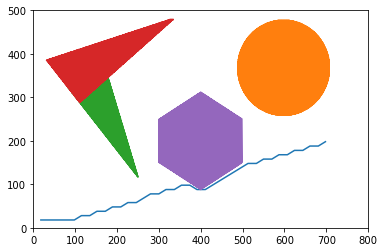

In [49]:

"""Backtracking"""

if (map_obs4[All_list[goal_id].node_loc[0], All_list[goal_id].node_loc[1],All_list[goal_id].node_loc[2]]!=-1 and map_obs4[All_list[goal_id].node_loc[0], All_list[goal_id].node_loc[1],All_list[goal_id].node_loc[2]]!=-2 ):
    x_a = []
    y_a = []
    backtrack(All_list, x_a, y_a)
    plt.show()
    plt.axis([0, 800, 0, 500])
    plt.plot(y_a,x_a)
    plt.plot(x_c, y_c)
    plt.plot(x_t1,y_t1)
    plt.plot(x_t2,y_t2)
    plt.plot(x_h,y_h)
else:
    print('cannot be back tracked')

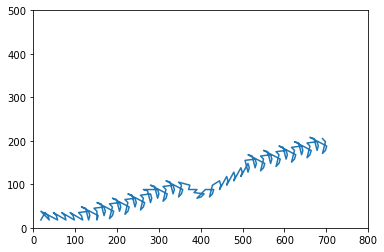

In [50]:
x_plot = []
y_plot = []
for i in All_list:
    
    x_plot.append(i.node_loc[1])
    y_plot.append(i.node_loc[0])
   
plt.axis([0, 400/Rat, 0, 250/Rat])
plt.plot(x_plot,y_plot)
# plt.plot(x_c, y_c)
# plt.plot(x_t1,y_t1)
# plt.plot(x_t2,y_t2)
# plt.plot(x_h,y_h)
plt.show()

In [59]:
def triang_obs():
    global x_t1, y_t1, x_t1_nc, y_t1_nc, map_obs2, x_t2_nc, y_t2_nc, x_t2, y_t2, allp_map, Rat
    x_t1 = []
    y_t1 = []
    x_t2 = []
    y_t2 = []
    x_t1_nc = []
    y_t1_nc = []
    x_t2_nc = []
    y_t2_nc = []
    map_obs2 = np.copy(map_obs1)
    for x in range(int(170/Rat)):
        for y in range(int(40*Rat),int(240/Rat)):
            if (y - (6/7)*x - ((779/7) + 15)/Rat)<=0 and (y - (-85/69)*x - ((15880/69) -18)/Rat)>=0 and (y - (-16/5)*x - ((2169/5) +25)/Rat)<=0 :
                map_obs2[y,x,:] = -1
                x_t1.append(x)
                y_t1.append(y)
                allp_map.append([x,y])
            if (y - (6/7)*x - ((779/7))/Rat)<=0 and (y - (-85/69)*x - ((15880/69))/Rat)>=0 and (y - (-16/5)*x - ((2169/5) +10)/Rat)<=0 :
                map_obs2[y,x,:] = -1
                x_t1_nc.append(x)
                y_t1_nc.append(y)
                allp_map.append([x,y])
            if (y - (6/7)*x - ((779/7) - 15)/Rat)>=0 and (y - (-85/69)*x - ((15880/69) -18)/Rat)>=0 and (y - (25/79)*x - ((13661/79) +15)/Rat)<=0:
                map_obs2[y,x,:] = -1
                x_t2.append(x)
                y_t2.append(y)
                allp_map.append([x,y])
            if (y - (6/7)*x - ((779/7) )/Rat)>=0 and (y - (-85/69)*x - ((15880/69))/Rat)>=0 and (y - (25/79)*x - ((13661/79))/Rat)<=0:
                map_obs2[y,x,:] = -1
                x_t2_nc.append(x)
                y_t2_nc.append(y)
                allp_map.append([x,y])

In [60]:
triang_obs()

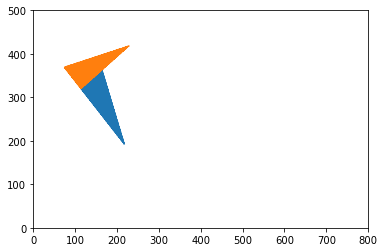

In [61]:
plt.axis([0, 400/Rat, 0, 250/Rat])
# plt.plot(x_a,y_a)
# plt.plot(x_c, y_c)
plt.plot(x_t1_nc,y_t1_nc)
plt.plot(x_t2_nc,y_t2_nc)
# plt.plot(x_h,y_h)
plt.show()

map is defined, initialising obstacle space
inside while
closed list updated
all list length is 1
popped
20 19 60
node created with id 2
node created at [20, 19, 2]
move 0
19 20 30
node created with id 3
node created at [19, 20, 1]
move 1
18 20 0
move 2
20 18 90
move 3
20 17 120
move 4
inside while
closed list updated
all list length is 3
popped
22 20 60
node created with id 4
node created at [22, 20, 2]
move 0
21 21 30
node created with id 5
node created at [21, 21, 1]
move 1
20 21 0
move 2
22 19 90
move 3
22 18 120
node created with id 6
node created at [22, 18, 4]
move 4
inside while
closed list updated
all list length is 6
popped
22 23 30
node created with id 7
node created at [22, 23, 1]
move 0
21 23 0
move 1
20 23 330
node created with id 8
node created at [20, 23, 11]
move 2
23 22 60
node created with id 9
node created at [23, 22, 2]
move 3
23 21 90
move 4
inside while
closed list updated
all list length is 9
popped
23 25 30
node created with id 10
node created at [23, 25, 1]
mo

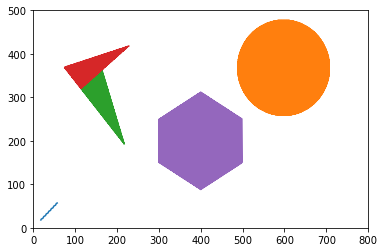

[18, 18, 2] 

[58, 54, 4]
[20, 19, 2] 

[18, 18, 2]
[19, 20, 1] 

[18, 18, 2]
[22, 20, 2] 

[20, 19, 2]
[21, 21, 1] 

[20, 19, 2]
[22, 18, 4] 

[20, 19, 2]
[22, 23, 1] 

[21, 21, 1]
[20, 23, 11] 

[21, 21, 1]
[23, 22, 2] 

[21, 21, 1]
[23, 25, 1] 

[22, 23, 1]
[21, 25, 11] 

[22, 23, 1]
[24, 24, 2] 

[22, 23, 1]
[26, 25, 2] 

[24, 24, 2]
[25, 26, 1] 

[24, 24, 2]
[26, 23, 4] 

[24, 24, 2]
[28, 26, 2] 

[26, 25, 2]
[27, 27, 1] 

[26, 25, 2]
[28, 24, 4] 

[26, 25, 2]
[28, 29, 1] 

[27, 27, 1]
[26, 29, 11] 

[27, 27, 1]
[29, 28, 2] 

[27, 27, 1]
[29, 31, 1] 

[28, 29, 1]
[27, 31, 11] 

[28, 29, 1]
[30, 30, 2] 

[28, 29, 1]
[32, 31, 2] 

[30, 30, 2]
[31, 32, 1] 

[30, 30, 2]
[32, 29, 4] 

[30, 30, 2]
[34, 32, 2] 

[32, 31, 2]
[33, 33, 1] 

[32, 31, 2]
[34, 30, 4] 

[32, 31, 2]
[34, 35, 1] 

[33, 33, 1]
[32, 35, 11] 

[33, 33, 1]
[35, 34, 2] 

[33, 33, 1]
[35, 37, 1] 

[34, 35, 1]
[33, 37, 11] 

[34, 35, 1]
[36, 36, 2] 

[34, 35, 1]
[38, 37, 2] 

[36, 36, 2]
[37, 38, 1] 

[36, 36, 2]
[38, 3

In [63]:
import numpy as np
import sympy as sp
import os
from queue import PriorityQueue

import matplotlib.pyplot as plt

#node size ratio (unit/node)
def map():
    global x_size, y_size, map_def
   
    x_size = int(400/Rat) #x and y  as per gloabl coordinate system and not matrix
    y_size = int(250/Rat)
    map_def = np.zeros((y_size,x_size,12))
    map_def[:,:,:] = -2

"""Common obstacle code"""



"""Circle"""

#x is column and y is row for the matrix
def circle_obs():
    global x_c, y_c, x_nc, y_nc, map_obs1, allp_map
    x_c = []
    y_c = []
    x_nc = []
    y_nc = []
    y_centre = int((249 - 65)/Rat)
    x_centre = int((399 - 100)/Rat)
    radius_c = int(55/Rat) #radius of cicle including clearance
    radius = int(40/Rat)
    map_obs1 = np.copy(map_def) # a deep copy #chnage this to map_obs1
    for x in range(int(240/Rat),int(360/Rat)):
        for y in range(int(120/Rat), int(240/Rat)):
            if (np.sqrt((x-x_centre)**2 + (y-y_centre)**2)) < radius_c:
                map_obs1[y, x,:] = -1 #obstacle space updated as -1
                x_c.append(x) #to be used for plotting
                y_c.append(y)
                allp_map.append([x,y]) #to be used for visualisation on pygame
            if (np.sqrt((x-x_centre)**2 + (y-y_centre)**2)) < radius:
                x_nc.append(x) #list of obstacle without clearance
                y_nc.append(y)

"""Triangles"""
def triang_obs():
    global x_t1, y_t1, x_t1_nc, y_t1_nc, map_obs2, x_t2_nc, y_t2_nc, x_t2, y_t2, allp_map, Rat
    x_t1 = []
    y_t1 = []
    x_t2 = []
    y_t2 = []
    x_t1_nc = []
    y_t1_nc = []
    x_t2_nc = []
    y_t2_nc = []
    map_obs2 = np.copy(map_obs1)
    for x in range(int(170/Rat)):
        for y in range(int(40*Rat),int(240/Rat)):
            if (y - (6/7)*x - ((779/7) + 15)/Rat)<=0 and (y - (-85/69)*x - ((15880/69) -18)/Rat)>=0 and (y - (-16/5)*x - ((2169/5) +25)/Rat)<=0 :
                map_obs2[y,x,:] = -1
                x_t1.append(x)
                y_t1.append(y)
                allp_map.append([x,y])
            if (y - (6/7)*x - ((779/7))/Rat)<=0 and (y - (-85/69)*x - ((15880/69))/Rat)>=0 and (y - (-16/5)*x - ((2169/5) +10)/Rat)<=0 :
                map_obs2[y,x,:] = -1
                x_t1_nc.append(x)
                y_t1_nc.append(y)
                allp_map.append([x,y])
            if (y - (6/7)*x - ((779/7) - 15)/Rat)>=0 and (y - (-85/69)*x - ((15880/69) -18)/Rat)>=0 and (y - (25/79)*x - ((13661/79) +15)/Rat)<=0:
                map_obs2[y,x,:] = -1
                x_t2.append(x)
                y_t2.append(y)
                allp_map.append([x,y])
            if (y - (6/7)*x - ((779/7) )/Rat)>=0 and (y - (-85/69)*x - ((15880/69))/Rat)>=0 and (y - (25/79)*x - ((13661/79))/Rat)<=0:
                map_obs2[y,x,:] = -1
                x_t2_nc.append(x)
                y_t2_nc.append(y)
                allp_map.append([x,y])

"""Hexagon"""

def hex_obs():
    global map_obs4, x_h, y_h, x_h_nc, y_h_nc, allp_map
    x_h = []
    y_h = []
    map_obs4 = np.copy(map_obs2)
    for x in range(int(148/Rat), int(252/Rat)):
        for y in range(int(30/Rat),int(165/Rat)):
            if (y - (5/8)*x + 81/Rat)>=0 and (y + (5/8)*x - 281/Rat)<=0 and (y - (5/8)*x - 31/Rat)<=0 and (y + (5/8)*x - 169/Rat)>=0 and (x - 249/Rat)<=0 and (x - 150/Rat)>=0:
                map_obs4[y,x,:] = -1
                x_h.append(x)
                y_h.append(y)
                allp_map.append([x,y])

"""The main algorithm

Data structure
"""

class Node:
    def __init__(self, node_id, node_loc, parent_id, c2c , c2g):
        self.parent_id = parent_id #
        self.node_id = node_id #unique node id for each node
        self.node_loc = node_loc ## [y,x,angle]
        self.c2c= round(c2c,0)
        self.c2g=round(c2g,2)
        self.total_cost = round(c2c+c2g,2)

def pop(Closed_list, Open_list, All_list):
    dat = Open_list.get()
    #dat[0] is c2c+c2g, dat[1] is Node_id--> starts from 1, list starts from 0 
    Closed_list.append(All_list[dat[1]-1]) #indexing the node from the all_list  
    ##check for goal
    print('closed list updated')
    if All_list[dat[1]-1].node_loc in goal_list:
        goal_id=dat[1]-1
        print('this will be done at', All_list[dat[1]-1].node_loc )
        print('the goal coast is', All_list[dat[1]-1].total_cost)
        return "Goal found", goal_id
    return 1, All_list[dat[1]-1]

"""Cost Dictionary"""

cost_direction = {'S': 1, 'D': 1}

"""Parameter update"""

def param(All_list, Open_list, map_obs4, cost_dir, n_c, n_d,ang, node):
     id = All_list[-1].node_id + 1
     map_obs4[n_c,n_d,int(ang/30)] = id  ## id is updated in map
     c2_g=c2g([n_c,n_d],goal_location[0:2])
     c2c=node.c2c+cost_dir
     cost = c2c+c2_g  #cost_dir is a dictionary
     parent = node.node_id
     loc = [n_c, n_d, int(ang/30)]
     # print('node at id', id, 'cost is', cost, 'loc', loc)
     All_list.append(Node(id, loc, parent, c2c,c2_g)) ## node is created
     tup_new = [cost, id]
     Open_list.put(tup_new) ## list of [cost, id] ###gives the [cost,id] in priority queue open list

"""List cost update function

All cost needs to be rounded off to 2 due to euclidean distance
"""

def cost_update(nod, n_c ,n_d, ang, All_list,  Closed_list, Open_list, map_obs4, cost_dir):
     index = int(map_obs4[n_c, n_d, int(ang/30)])
     if round((nod.c2c + cost_dir),1)< round(All_list[index-1].c2c,1): #since index/node_id is starting from 1
            All_list[index-1].c2c = round((nod.c2c + cost_dir),1)
            All_list[index-1].parent_id = nod.node_id
            print('updated cost of node', index, 'is', All_list[index-1].total_cost)
            # for i in Closed_list:
            #     if i.node_id ==index:
            #             i.c2c = round((nod.c2c + cost_dir),1)
            #             i.parent_id = nod.node_id
            if Open_list.qsize() > 0:
                for j in Open_list.queue:
                    if j[1] ==index:
                            j[0] = round((nod.c2c + cost_dir),1)
                            # i.parent_id = nod.node_id

"""Check if goal function"""

# def check_if_goal(goal_loc, A_list, go_cost):
#     # print('checking goal')
#     if goal_loc==A_list[-1].node_loc:
#         go_cost = A_list[-1].cost #updates the goal cost
#         print('goal cost is', go_cost)
#         return go_cost
#     else:
#         return None

def move_zero(node, All_list, Open_list, k):
    a,b, node_k =node.node_loc
    angle=node_k*30
    ang=(angle+k*30)%360
    c= a + (L*np.sin(ang*(np.pi/180)))/Rat #needs to be according to the matrix
    d= b + (L*np.cos(ang*(np.pi/180)))/Rat
    n_c, n_d=thres_round(c,d)
    print(n_c, n_d, ang)
    if (9/Rat)<=(n_c)<=(y_size-1) and (9/Rat)<=n_d<=(x_size-1) and (a!=c) and (b!=d): 
        if map_obs4[n_c,n_d,int(ang/30)]==-2:
            param(All_list, Open_list, map_obs4, cost_direction['S'], n_c, n_d, ang, node) 
            print('node created with id', All_list[-1].node_id)
            return print('node created at', All_list[-1].node_loc)
            
        elif map_obs4[n_c,n_d, int(ang/30)]==-1:
            print('Obstacle space')
            return None
        
        else:
            print('Node exists, checking cost...')
            cost_update(node, n_c ,n_d,ang, All_list,  Closed_list, Open_list, map_obs4, cost_direction['S'])  
            return None
    else:
        return None

def thres_round(c,d):
    # Rat=0.5
    n_c=np.round(c,0)
    n_d=np.round(d,0)

    return int(n_c),int(n_d)

def movement(node, All_list, Open_list):
    move_zero(node, All_list, Open_list,0)
    print('move 0')
    move_zero(node, All_list, Open_list,-1)
    print('move 1')
    move_zero(node, All_list, Open_list,-2)
    print('move 2')
    move_zero(node, All_list, Open_list,1)
    print('move 3')
    move_zero(node, All_list, Open_list,2)
    print('move 4')

"""considering a radius of 1.5 for goal space:"""

#passed input is as per the user
def goal_space(goal_x, goal_y, k):
    centre_x = goal_x
    centre_y = goal_y
    goal_list = []
    for i in range(goal_x-int(3/Rat),goal_x+int(3/Rat)):
        for j in range(goal_y-int(3/Rat), goal_y+int(3/Rat)):
            if (i-centre_x)**2 + (j-centre_y)**2<=2.25/Rat:
                goal_list.append([j,i,k])
    return goal_list 
    #output is as per the matrix


def c2g(initial, final):
    
    return np.round(np.linalg.norm(np.array(initial)-np.array(final)),2)

"""x,y-world coordinate
x,y,k--- angle in terms of degrees
k --- 0,11 
angle =k*30
"""

def initial():
    global All_list, Closed_list, goal_location, Open_list, allp_map, goal_list
    allp_map = []
    All_list = []
    Closed_list = []
    goal_list = []
    first_node_id = 1
    start_cords_x = 10##int(input("please enter the starting x coordinate: "))
    start_cords_y = 10##int(input("please enter the starting y coordinate: "))
    start_angle=60 ##int(input("please enter the starting angle"))
    start_k=int(start_angle/30)
    # if start_cords_x<1 or start_cords_x>400 or start_cords_y<1 or start_cords_y>400:
    #     print("Either wrong input or the start node is in obstacle space")
    #     exit(0)
    # else:
    #     node_loc = [start_cords_y-1, start_cords_x-1]
    start_location = [int((start_cords_y-1)/Rat), int((start_cords_x-1)/Rat), start_k]
    goal_cords_x = 30##int(input("please enter the goal x coordinate: "))
    goal_cords_y = 30 ##int(input("please enter the goal y coordinate: "))
    goal_angle=30 ##int(input("please enter the goal angle"))
    goal_k=int(goal_angle/30)
    # if goal_cords_x<1 or goal_cords_x>400 or goal_cords_y<1 or goal_cords_y>400:
    #     print("Either wrong input or the goal node is in obstacle space")
    #     exit(0)
    # else:
    #     goal_location = [goal_cords_y-1, goal_cords_x-1] ### change
    goal_location = [int((goal_cords_y-1)/Rat), (int(goal_cords_x-1)/Rat),goal_k]
    goal_list = goal_space(int((goal_cords_x-1)/Rat), int((goal_cords_y-1)/Rat), goal_k)
    map()
    print('map is defined, initialising obstacle space')
    circle_obs()
    triang_obs()
    hex_obs()
    if map_obs4[int((start_cords_y-1)/Rat), int((start_cords_x-1)/Rat), start_k]==-1 or map_obs4[int((goal_cords_y-1)/Rat), int((goal_cords_x-1)/Rat), goal_k]==-1:
        print("start or goal node in obstacle space")
        exit(0)
    else:
        map_obs4[int((start_cords_y-1)/Rat), int((start_cords_x-1)/Rat), start_k] = first_node_id
        first_parent_id = 0
        initial_c2g=c2g(start_location[0:2], goal_location[0:2])
        first_cost = 0+initial_c2g
        All_list.append(Node(first_node_id, start_location, first_parent_id,0,initial_c2g))
        tup = [first_cost, first_node_id] # just the cost and node id, access the node using all visited and node id
        Open_list = PriorityQueue()
        Open_list.put(tup)

Rat = 0.5 #unit per node
L=1 #can be from 1 to 10
initial()




"""Take the input from user"""

##goal_cost = np.inf
while(1):
    if (Open_list.qsize()>0):
        

        print('inside while')
        r,node =pop(Closed_list, Open_list, All_list)
        print('all list length is', len(All_list))
        if type(r) == str:
            print('done')
            goal_id=node
            # plt.scatter(x_c, y_c)
            # plt.scatter(x_h, y_h)
            # plt.scatter(x_t1, y_t1)
            # plt.scatter(x_t2, y_t2)
            # plt.axis([0, 400/Rat, 0, 250/Rat])
            # plt.show
            break
        else:
            print('popped')

        # print('closed list', len(Closed_list))
        # print('openlist', len(Open_list))
            movement(node, All_list, Open_list)
            # print('check is', check)
        #     if(check!=None):
        #         print('mila na')
        #         goal_cost = All_list[int(map_obs4[goal_location[0],goal_location[1]]-1)].cost

        #         print('goal cost is', goal_cost)
        # else:
        #     print('cost exceeded')
        #     break
    
    else:
        print('open list empty')
        break

# All_list[-1].node_loc

# goal_list

# Open_list.qsize()

# len(All_list)

# len(allp_map)
def backtrack(A_list, x, y):
    ind = int(map_obs4[All_list[goal_id].node_loc[0], All_list[goal_id].node_loc[1],All_list[goal_id].node_loc[2]])
    y.append(A_list[ind-1].node_loc[0])
    x.append(A_list[ind-1].node_loc[1])
    id = A_list[ind-1].parent_id
    while(id>0):
        x.append(A_list[id-1].node_loc[0])
        y.append(A_list[id-1].node_loc[1])
        id = A_list[id - 1].parent_id

if (map_obs4[All_list[goal_id].node_loc[0], All_list[goal_id].node_loc[1],All_list[goal_id].node_loc[2]]!=-1 and map_obs4[All_list[goal_id].node_loc[0], All_list[goal_id].node_loc[1],All_list[goal_id].node_loc[2]]!=-2 ):
    x_a = []
    y_a = []
    backtrack(All_list, y_a, x_a)
    plt.axis([0, 400/Rat, 0, 250/Rat])
    plt.plot(x_a,y_a)
    plt.plot(x_c, y_c)
    plt.plot(x_t1_nc,y_t1_nc)
    plt.plot(x_t2_nc,y_t2_nc)
    plt.plot(x_h,y_h)
    plt.show()
else:
    print('cannot be back tracked')

x_plot = []
y_plot = []


#optimized
# for i in All_list:
    
#     x_plot.append(i.node_loc[1])
#     y_plot.append(i.node_loc[0])
   
# plt.axis([0, 400/Rat, 0, 250/Rat])
# plt.plot(x_plot,y_plot)
# # plt.plot(x_c, y_c)
# # plt.plot(x_t1,y_t1)
# # plt.plot(x_t2,y_t2)
# # plt.plot(x_h,y_h)
# plt.show()

for i in All_list:

    print(i.node_loc, '\n')
    id = i.parent_id
    print(All_list[id-1].node_loc)